# Checking impact of salinity restoring relative to meltwater perturbation

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from gsw import SA_from_SP, p_from_z
from pathlib import Path

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/IAF_meltwater/'

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33829/status,
Dashboard: /proxy/33829/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45955,Workers: 28
Dashboard: /proxy/33829/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:43739,Total threads: 1
Dashboard: /proxy/44595/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45795,


#### Importing the data

In [3]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))[24:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

pathsC_out = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month.nc'))[24:]
pathsM_out = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month.nc'))

In [4]:
lat_slice = slice(-79,-59)

In [5]:
# Time variant variables
def preprocess_1(ds):
    ds = ds[['z_l','so']].sel(yh=lat_slice) 
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess_1, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess_1, chunks = 'auto')

In [6]:
# Time variant variables
def preprocess_2(ds):
    ds = ds[['salt_flux_added','lrunoff']].sel(yh=lat_slice) 
    return ds

cont_out = xr.open_mfdataset(pathsC_out, preprocess = preprocess_2, chunks = 'auto')
melt_out = xr.open_mfdataset(pathsM_out, preprocess = preprocess_2, chunks = 'auto')

In [7]:
# Grid variables
path_to_ocean_static_01 = Path('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_static.nc')
grid01 = xr.open_dataset(path_to_ocean_static_01)

In [8]:
# Trim time
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

cont_out = cont_out.sel(time=slice('2001-01-01','2010-12-31'))
melt_out = melt_out.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
# topography data for plotting:
deptho = grid01['deptho'].sel(yh=slice(-79,-59)) 
land_mask = np.squeeze(deptho.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
#land_mask_lat = ht.yt_ocean.values
#land_mask_lat[0] = -90

fontsize=15

### Time series of restoring over shelf

In [10]:
# shelf masking:
contour_file = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')
shelf_mask = contour_file['contour_masked_above'].to_numpy()
yh = contour_file['yh'] #slice to match lat_slice
xh = contour_file['xh']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yh', yh.values), ('xh', xh.values)])



In [11]:
area_old = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello'].sel(yh=lat_slice)
var = cont['so'].isel(time=0,z_l=0)
area_corr = area_old*(var*0 +1)
area = (area_corr*shelf_mask).load()
area_sum = area.sum(dim={'xh','yh'}).load()

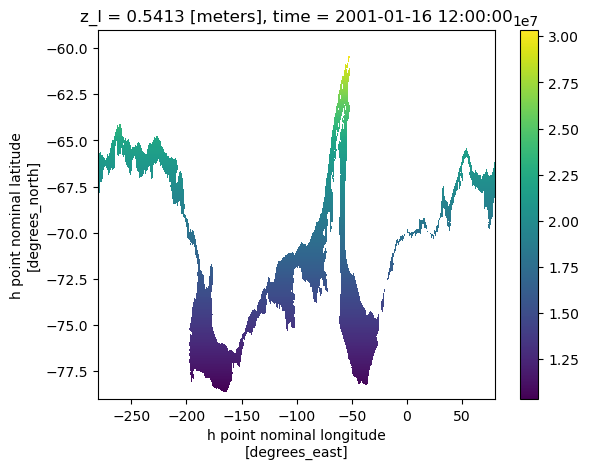

In [12]:
area.plot()

In [13]:
# stuff needed for absolute salinity conversion:
z_l = cont['z_l'].load()
geolon = grid01['geolon'].sel(yh=lat_slice).load()
geolat = grid01['geolat'].sel(yh=lat_slice).load()
depth_tile = -(geolat*0+1)*z_l[0].values
pressure = xr.DataArray(p_from_z(depth_tile,geolat), coords = [('yh', yh[:460].values), ('xh', xh.values)], dims = ['yh', 'xh'], 
                        name = 'pressure', attrs = {'units':'dbar'}) #slice to match lat_slice

In [14]:
SSS_prac = cont['so'].sel(yh=lat_slice).sel(z_l=0,method='nearest')
# convert units to absolute salinity:
SSS_con = xr.DataArray(SA_from_SP(SSS_prac,pressure,geolon,geolat), coords = [SSS_prac.time, SSS_prac.yh, SSS_prac.xh], 
                       dims = ['time','yh', 'xh'], name = 'sea surface salinity', 
                       attrs = {'units':'Absolute Salinity (g/kg)'})

restoring_con = cont_out['salt_flux_added'].sel(yh=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
restoring_con = restoring_con*1000/SSS_con

# restrict to shelf and integrate over area:
restoring_con = (restoring_con*area).sum('xh').sum('yh')/area_sum
restoring_con = restoring_con.load()

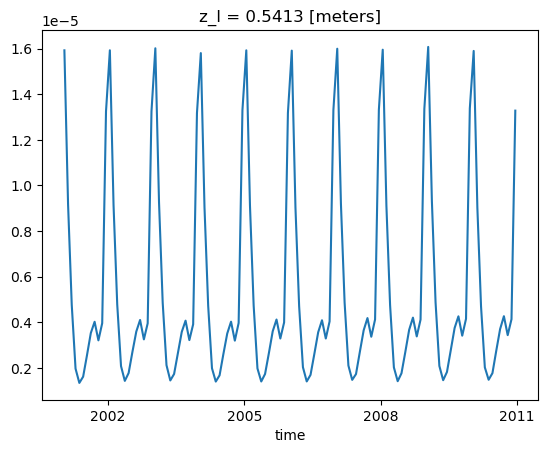

In [15]:
restoring_con.plot()

In [16]:
SSS_prac = melt['so'].sel(yh=lat_slice).sel(z_l=0,method='nearest')

# convert units to absolute salinity:
SSS_melt = xr.DataArray(SA_from_SP(SSS_prac,pressure,geolon,geolat), coords = [SSS_prac.time, SSS_prac.yh, SSS_prac.xh], 
                       dims = ['time','yh', 'xh'], name = 'sea surface salinity', 
                       attrs = {'units':'Absolute Salinity (g/kg)'})

restoring_melt = melt_out['salt_flux_added'].sel(yh=lat_slice)

# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
restoring_melt = restoring_melt*1000/SSS_melt

# restrict to shelf and integrate over area:
restoring_melt = (restoring_melt*area).sum('xh').sum('yh')/area_sum
restoring_melt = restoring_melt.load()

In [17]:
# compare to runoff:

runoff_con = cont_out['lrunoff'].sel(yh=lat_slice)
# restrict to shelf and integrate over area:
runoff_con = (runoff_con*area).sum('xh').sum('yh')/area_sum
runoff_con = runoff_con.load()

runoff_melt = melt_out['lrunoff'].sel(yh=lat_slice)
# restrict to shelf and integrate over area:
runoff_melt = (runoff_melt*area).sum('xh').sum('yh')/area_sum
runoff_melt = runoff_melt.load()

Text(0.5, 1.0, 'Runoff and restoring integrated over shelf')

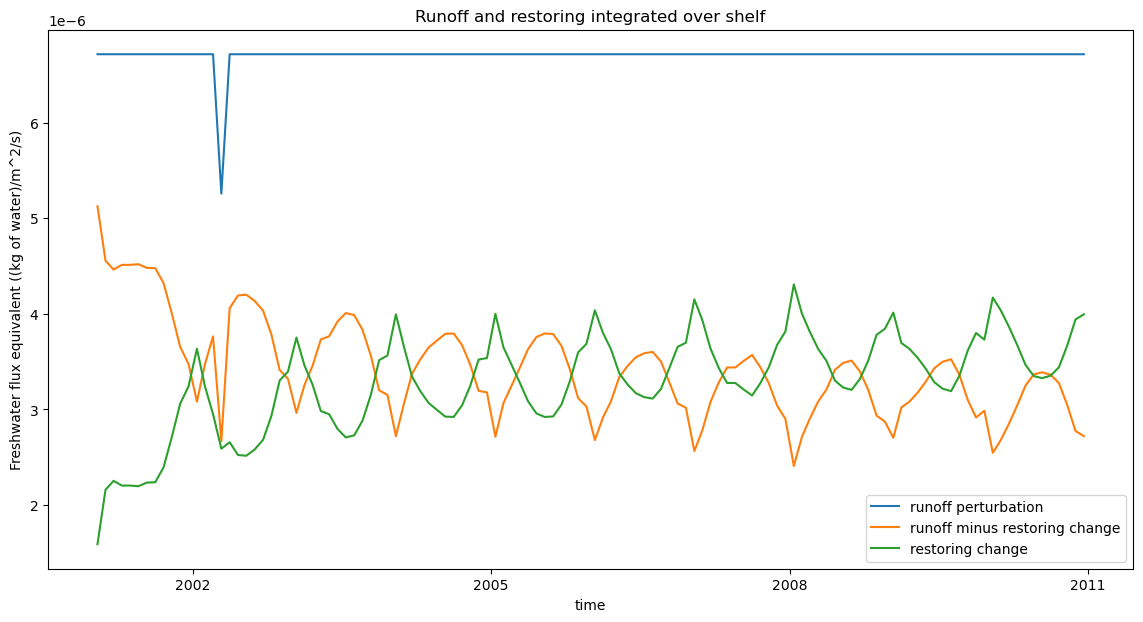

In [18]:
# units of both should be (kg of water)/m^2/s averaged over the shelf:

plt.figure(figsize=(14,7))
(runoff_melt - runoff_con).plot(label='runoff perturbation')
((runoff_melt - runoff_con)-(restoring_melt - restoring_con)).plot(label='runoff minus restoring change')
((restoring_melt - restoring_con)).plot(label='restoring change')
plt.legend()
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf')
#plt.ylim(0,2.1e-6)

In [19]:
runoff_pert = (runoff_melt - runoff_con)
runoff_minus_restoring_change = (runoff_melt - runoff_con) - (restoring_melt - restoring_con)
restoring_change = (restoring_melt - restoring_con)

In [20]:
runoff_pert.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/runoff_pert_pan01.nc')
runoff_minus_restoring_change.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/runoff_minus_restoring_change_pan01.nc')
restoring_change.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_change_pan01.nc')

### Confirming area mask

In [21]:
area

<xarray.DataArray (yh: 460, xh: 3600)> Size: 7MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -59.14 -59.08 -59.03
    z_l      float64 8B 0.5413
    time     object 8B 2001-01-16 12:00:00

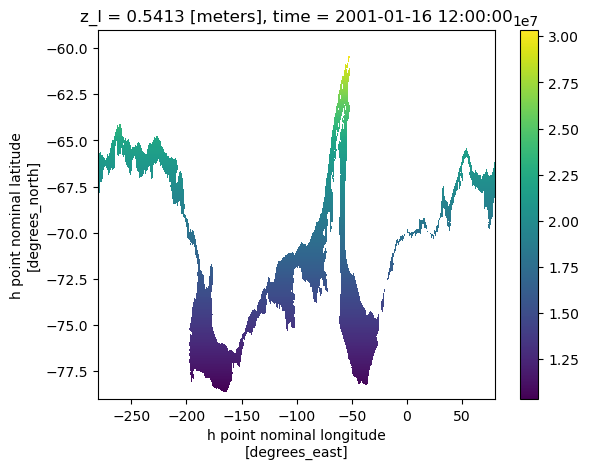

In [22]:
area.plot()